In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from multiprocessing import Pool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_7/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [5]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

In [3]:
#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

In [6]:
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

#aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)

Log Likelihood with Regularization: 898.3437975326829
Log Evidence: 581.1296008742142
Log Likelihood : 1066.480031595932


In [8]:
boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                 'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.80, 1.20]}


def prior_transform(theta):
    ml, kappa_s, qDM, log_mbh, mag_shear, phi_shear, gamma = theta
    parsDic = {"ml": ml, "kappa_s": kappa_s, "qDM": qDM,
                    "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                    "gamma": gamma}
    for key in parsDic:
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
    return np.array(list(parsDic.values()))

def log_likelihood(pars):
    quiet=False
    ml_model, kappa_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
    
    ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
    eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s) #Set the analytical model
    mass_profile.Analytic_Model(eNFW)        #Include analytical model
    mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
    shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
    #New lens model
    lens_galaxy = al.Galaxy(                                            
            redshift=mass_profile.z_l,
            mass=mass_profile,
            shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
        )

    source_galaxy = al.Galaxy(
            redshift=mass_profile.z_s,
            pixelization=al.pix.Rectangular(shape=(40, 40)),
            regularization=al.reg.Constant(coefficient=1.5),
        )
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
    
    try:
        fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

        log_evidence = fit.log_evidence

            
        if quiet is False:
            print("Lens Galaxy Configuration:")
            print("Log Likelihood_with_regularization:", fit.log_likelihood)
            print("Log Normalization", fit.log_likelihood)
            print("Log Evidence:", fit.log_evidence)
            print("#------------------------------------#")
            print(lens_galaxy)
            print("\n")


            aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
            aplt.Inversion.reconstruction(fit.inversion)              


        return log_evidence
    except:
        print("An exception ocurres in Pyautolens_log_likelihood().")
        return -np.inf


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 1066.480031595932
Log Normalization 1066.480031595932
Log Evidence: 581.1296008742142
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 4.1
critical_density: 2108482862924014.2
surf_lum: [18346.292692  5678.080985   819.007822   267.058249   168.708624
    69.166644    54.760253    23.669855]
sigma_lum: [0.04569  0.130028 0.255286 0.588301 0.668833 1.224185 1.760555 3.255514]
qobs_lum: [0.689692 0.551571 0.827813 1.       0.55     1.       0.606143 0.782576]
ml: 7.0
surf_dm: None
sigma_dm: None
qobs_dm: None
mbh: 1000000000.0
sigma_mbh: 0.01
qobs_mbh: 1.0
D_l: 945.3773958098793 Mpc
D_s: 1452.7315140083595 Mpc
D_ls: 1

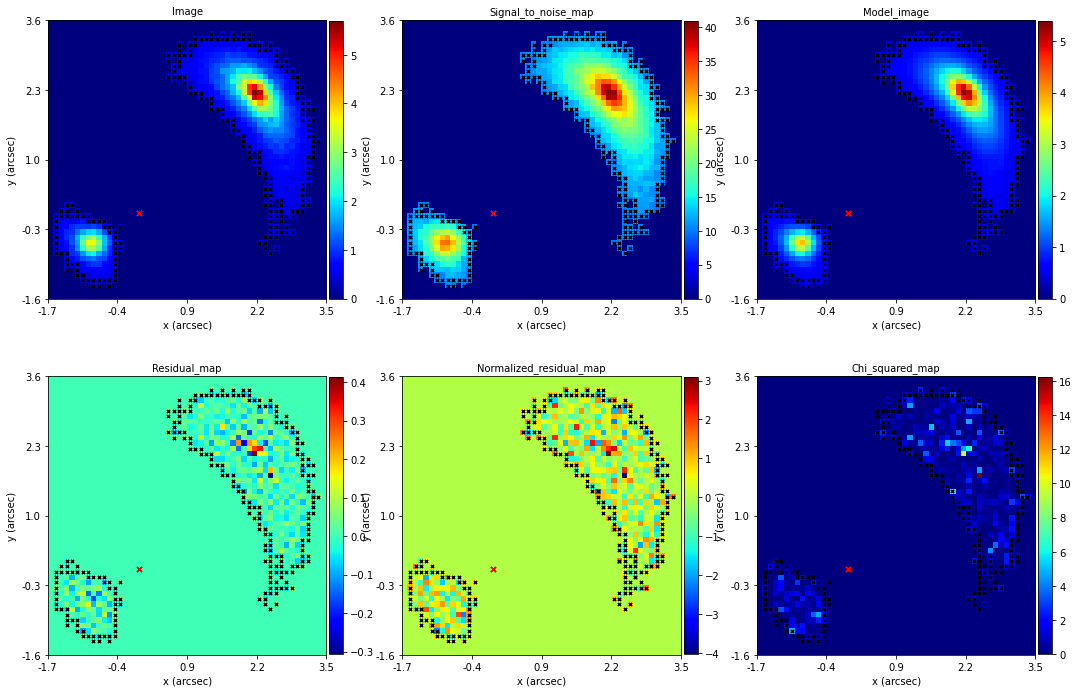

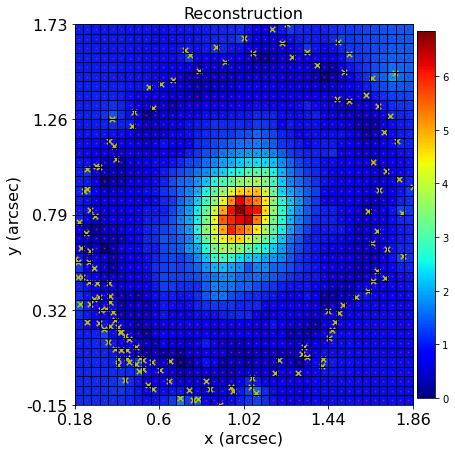

Array(581.12960087)

In [9]:
# ml, kappa_s, qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, kappa_, qobs_dm[0], np.log10(mbh), 0.02, 88., 1.0])
log_likelihood(p0)

In [10]:
from dynesty import NestedSampler

nlive = 100              # number of (initial) live points
ndim  = p0.size          #number of dimensions


# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive)

In [11]:
import pickle 
import shutil

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


labels = ["ml", "kappa_s", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]



original = r"dynesty_lens.pickle"
beckup   = r"beckup/dynesty_lens_beckup.pickle"

start = time.time()
for it, res in enumerate(sampler.sample()):
    if (it+1) % 100:
        continue
    
    print("Saving...")
    with open(f"dynesty_lens.pickle", "wb") as f:
                pickle.dump(sampler, f)
    print("File Save!")
    print(sampler.results.summary())
    print("Cumulative Time [s]:", (time.time() - start))
    print("#############################")
    print("\n")
    
    beckup = shutil.copyfile(original, beckup)
    
    


## Loading Run 1

In [12]:
import pickle
with open(f'dynesty_lens_75w.pickle','rb') as f:
    sample_load = pickle.load(f)

In [13]:
sample_load.results["logz"].shape

(9950,)

In [14]:
sample_load.results["logz"][-1] - sample_load.results["logz"][9950-2]

0.005889113080684183

In [15]:
# Adding the final set of live points.
for it_final, res in enumerate(sample_load.add_live_points()):
    pass

In [16]:
sample_load.results["logz"].shape

(10974,)

In [17]:
sample_load.results["logz"][-1] - sample_load.results["logz"][10974-2]

0.9083660462215448

In [18]:
sample_load.results.summary()

Summary
nlive: 1024
niter: 9950
ncall: 201606
eff(%):  5.443
logz: 581.669 +/-  1.095


In [22]:
truths = p0
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sample_load.results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean

array([6.15274131e+00, 1.00571173e-01, 7.90912190e-01, 9.53796641e+00,
       8.20704414e-03, 1.15554993e+02, 1.02027681e+00])

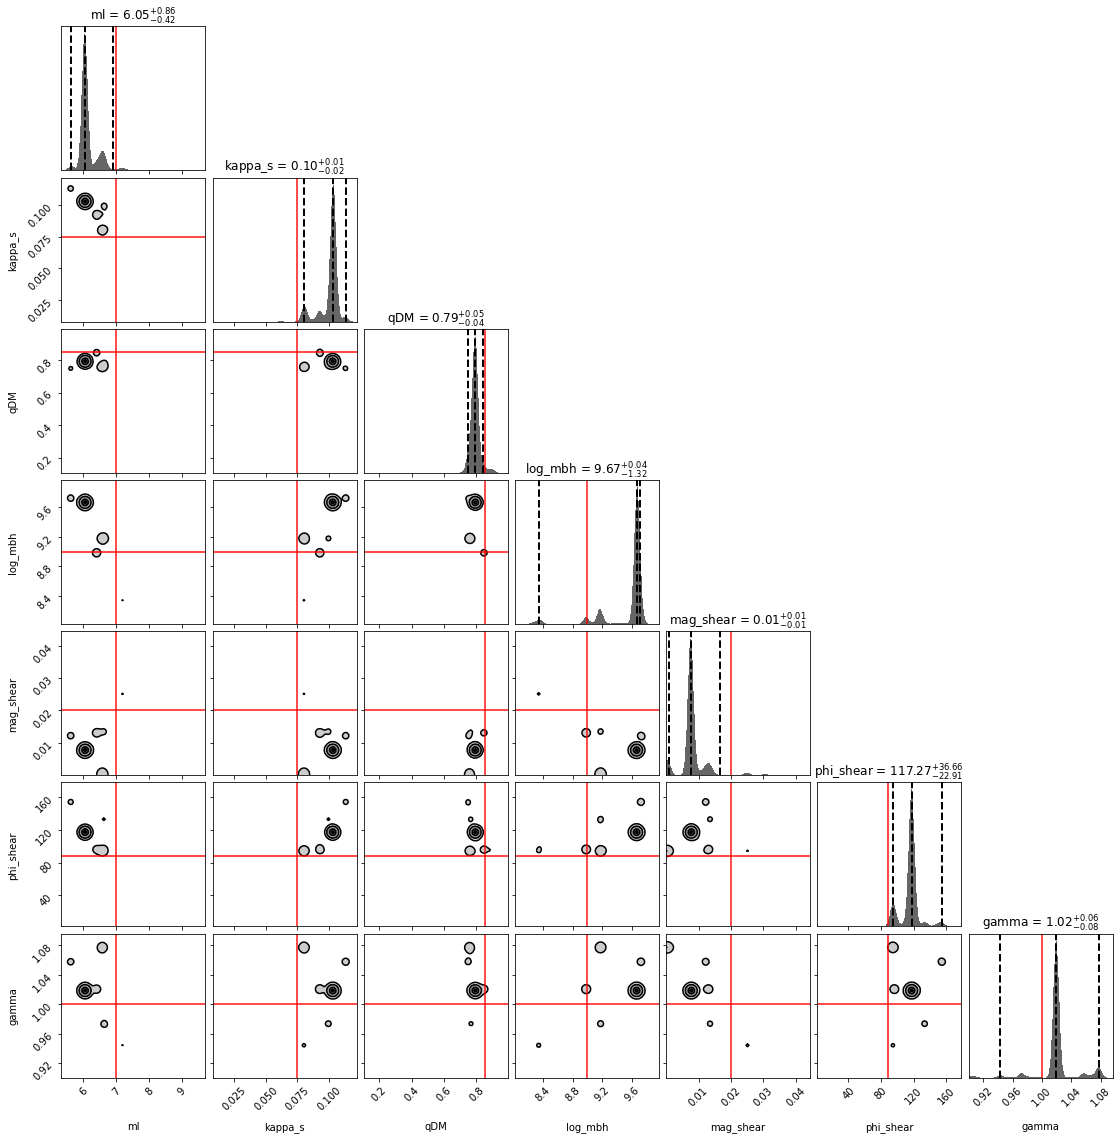

In [23]:
# Plot the 2-D marginalized posteriors.
labels = ["ml", "kappa_s", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim,truths=truths, show_titles=True,labels=labels,
                               )

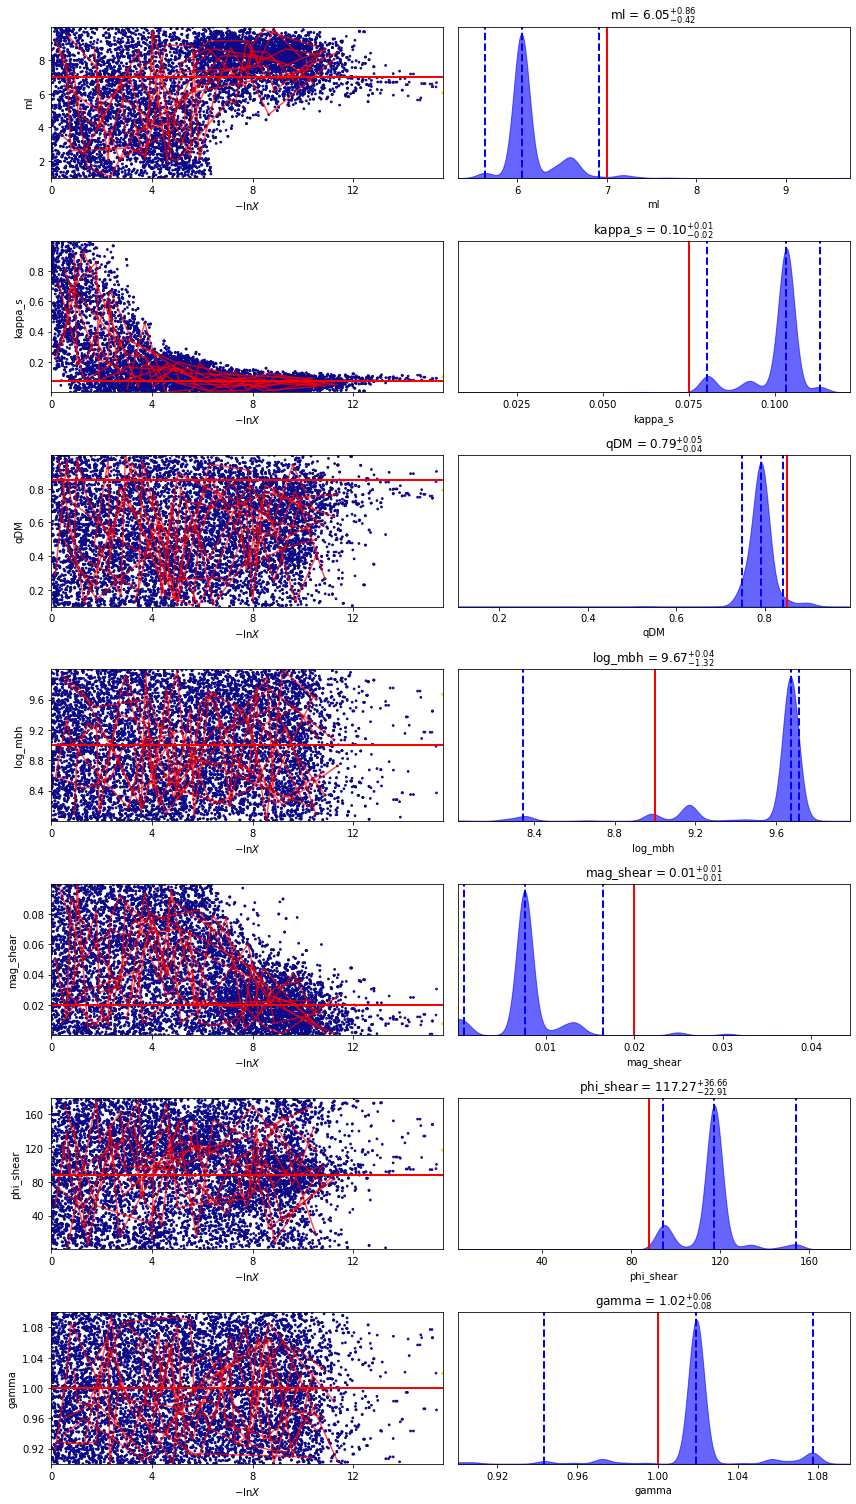

In [24]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels, 
                               truths=p0, show_titles=True, connect=True)
plt.tight_layout()

In [26]:
mean

array([6.15274131e+00, 1.00571173e-01, 7.90912190e-01, 9.53796641e+00,
       8.20704414e-03, 1.15554993e+02, 1.02027681e+00])

Lens Galaxy Configuration:
Log Likelihood_with_regularization: 1080.4366740554237
Log Normalization 1080.4366740554237
Log Evidence: 597.9260719771942
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0202768057916833
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.11674933648784667)
axis_ratio: 0.7909121900980557
phi: 0.0
kappa_s: 0.10057117306963877
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 4.1
critical_density: 2108482862924014.2
surf_lum: [18346.292692  5678.080985   819.007822   267.058249   168.708624
    69.166644    54.760253    23.669855]
sigma_lum: [0.04569  0.130028 0.255286 0.588301 0.668833 1.224185 1.760555 3.255514]
qobs_lum: [0.689692 0.551571 0.827813 1.       0.55     1.       0.606143 0.782576]
ml: 6.152741307331502
surf_dm: None
sigma_dm: None
qobs_dm: None
mbh: 3451170494.431194
sigma_mbh: 0.01
qobs_mbh: 1.0
D_l: 945.377

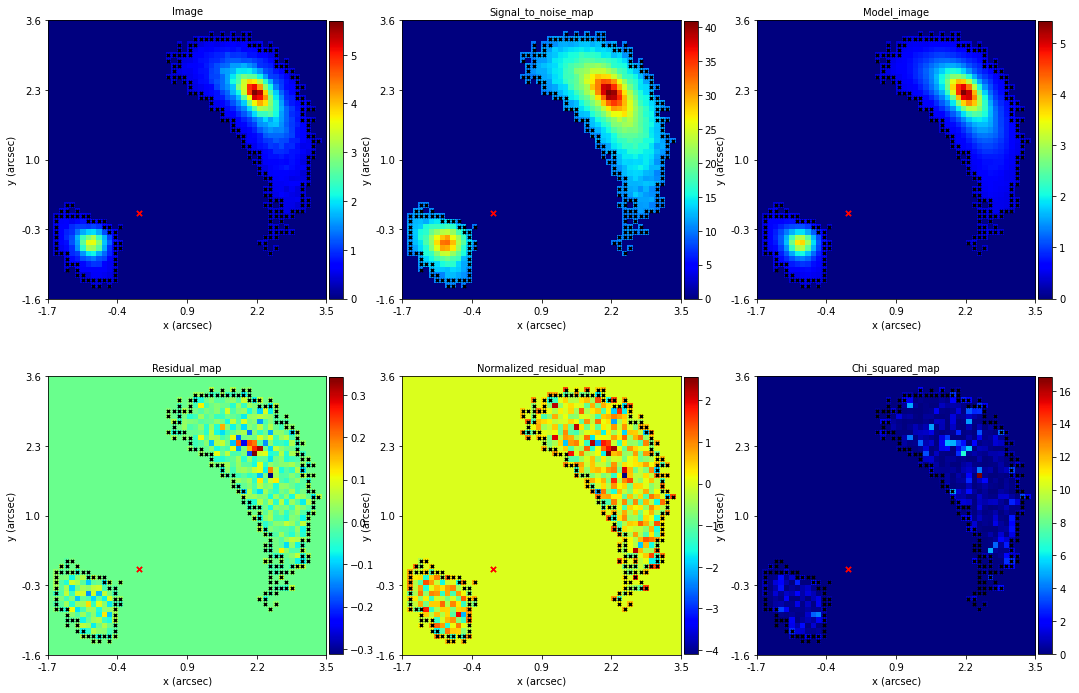

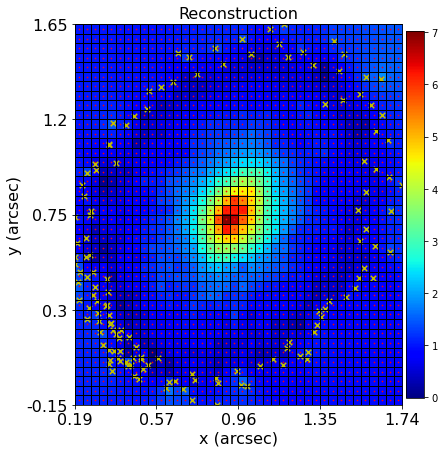

Array(597.92607198)

In [28]:
log_likelihood(mean)

In [67]:
Log Likelihood with Regularization: 898.3437975326829
Log Evidence: 581.1296008742142
Log Likelihood : 1066.480031595932

array([6.55782059e+00, 8.37966776e-02, 8.34656520e-01, 1.00806057e+01,
       4.85298250e-02, 8.92992122e+01, 9.86295221e-01])